In [1]:
import numpy as np
import pandas as pd
import os
import math
import time
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from datetime import *
from collections import *
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import rcParams
import xlrd as xl
import csv
import os
import math
from scipy import stats
import csv
from matplotlib.pyplot import figure
import matplotlib
from sklearn.metrics import mean_squared_error as rmse
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, DotProduct
import seaborn as sns
from scipy import stats

#import numpy as np
#import matplotlib.pyplot as plt
#from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, DotProduct, RBF, Matern, WhiteKernel, ExpSineSquared, RationalQuadratic
import warnings

#calculate the distance
#!pip install haversine
from haversine import haversine, Unit


from sklearn.preprocessing import StandardScaler

#source code
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
import time

#calculate the similarity
from scipy.spatial.distance import cosine, hamming, jaccard

In [2]:
path = "G:/My Drive/2021/Bias/sumo_simulation/"
os.chdir(path)

#get obs data matrix
data_path_lst = []
for i in os.listdir():
    if len(i) == 12 and '.csv' in i:
        data_path_lst.append(i)
data_path_lst

['20170404.csv',
 '20170405.csv',
 '20170411.csv',
 '20170406.csv',
 '20170419.csv',
 '20170418.csv',
 '20170413.csv',
 '20170412.csv',
 '20170427.csv',
 '20170426.csv',
 '20170420.csv',
 '20170425.csv']

In [3]:
#count data in ids
def count_id(datapath):
    dt = pd.read_csv(datapath)
    newids = np.unique(dt['newid'])
    return(newids)

def getid_descrip(curdict, newids):
    for i in newids:
        if i not in curdict:
            curdict[i] = 1
        else:
            curdict[i] += 1
    return(curdict)

iddict = {}
for i in data_path_lst:
    curids = count_id(i)
    iddict = getid_descrip(iddict, curids)

(array([23938.,  8809.,  4923.,  2527.,  2008.,  1777.,  1412.,  1311.,
         1292.,  1045.,  1048.,  1468.]),
 array([ 1.        ,  1.91666667,  2.83333333,  3.75      ,  4.66666667,
         5.58333333,  6.5       ,  7.41666667,  8.33333333,  9.25      ,
        10.16666667, 11.08333333, 12.        ]),
 <BarContainer object of 12 artists>)

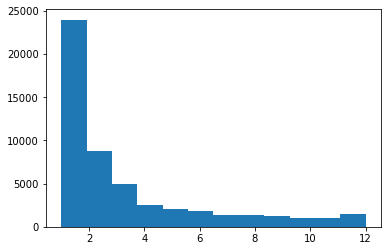

In [4]:
plt.hist(iddict.values(), bins=12)

In [5]:
#check ids with obs = 12 days
numdays = 12
idarr = np.vstack((np.array(list(iddict.keys())), np.array(list(iddict.values())))).T
ids = idarr[:, 0][idarr[:,1]==numdays]

In [6]:
def get_databyid(idlst, inputdt, datapath, idx):
    dt = pd.read_csv(datapath)
    dt = dt[dt['newid'].isin(idlst)]
    #print(dt.shape)
    if idx != 0:
        outputdt = pd.concat([inputdt, dt], axis=0)
        return outputdt
    else:
        return dt

idx = 0
for i in data_path_lst:
    if idx == 0:
        dt12days = get_databyid(ids, None, i, idx)
        idx = 1
    else:
        dt12days = get_databyid(ids, dt12days, i, idx)

In [7]:
#taz index data processing
#convert taz and time idx
idx = 1
tazidx = {}
idxtaz = {}
for i in np.unique(dt12days['taz']):
    tazidx[i] = idx        
    idxtaz[idx] = i
    idx += 1
taz2idx = lambda x: tazidx[x]

dt12days['tazidx'] = dt12days['taz'].apply(taz2idx)

str2time = lambda x: int(int(x.split(':')[0])*12 + int(x.split(':')[1])/5)
dt12days['timeidx'] = dt12days['time'].apply(str2time)

dt12days = dt12days.sort_values(by=['newid', 'date', 'timeidx'])

C:\Users\Yiran\AppData\Local\Temp\ipykernel_44840\1608797316.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdt['timeidx'] = testdt['time'].apply(str2time)
C:\Users\Yiran\AppData\Local\Temp\ipykernel_44840\1608797316.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdt['timeidx'] = testdt['time'].apply(str2time)
C:\Users\Yiran\AppData\Local\Temp\ipykernel_44840\1608797316.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

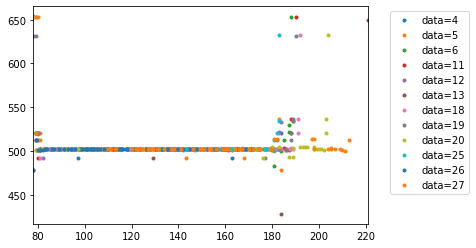

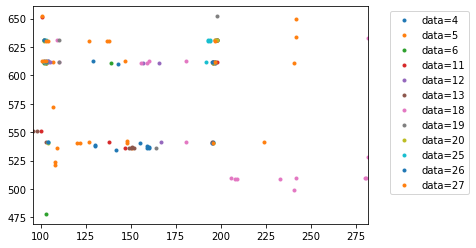

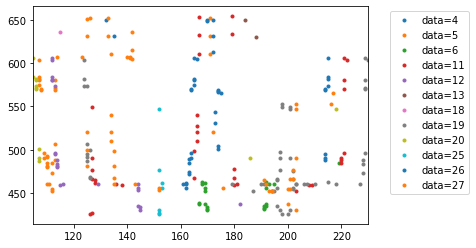

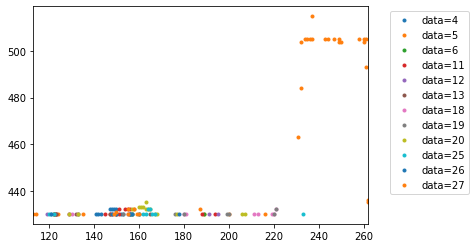

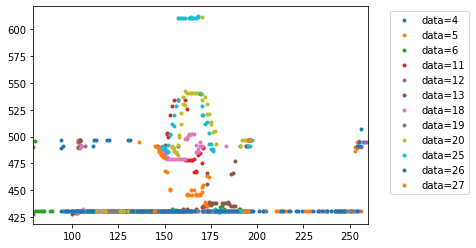

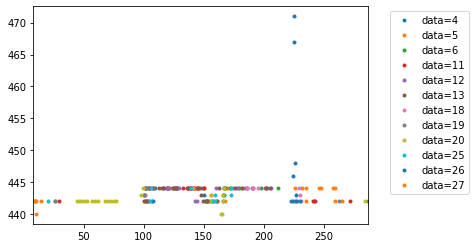

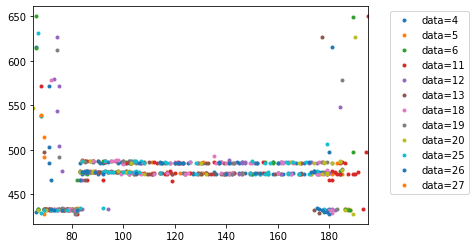

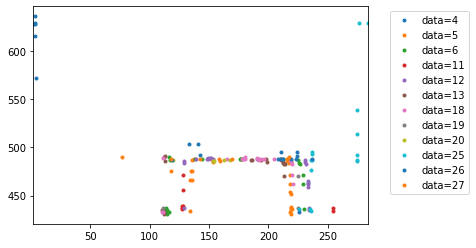

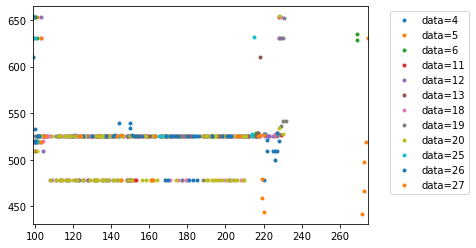

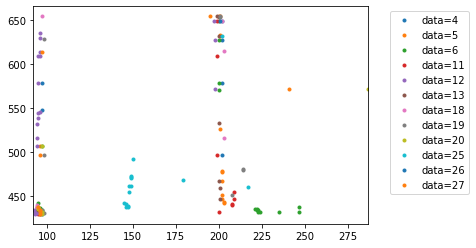

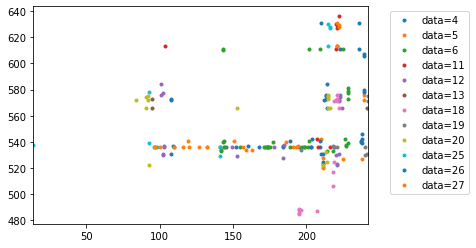

In [8]:
idx = 0
for newid in ids:
    if idx <= 10:
        testdt = dt12days[dt12days['newid']==newid]
        str2time = lambda x: int(int(x.split(':')[0])*12 + int(x.split(':')[1])/5)
        testdt['timeidx'] = testdt['time'].apply(str2time)

        #check the zone trajectory
        testdt.sort_values(by=['date', 'timeidx'])
        timeidx = np.unique(testdt['timeidx'])
        days = np.unique(testdt['date'])

        mintime = min(timeidx)
        maxtime = max(timeidx)

        plt.figure(newid)
        for d in days:
            daydt = testdt[testdt['date']==d].sort_values(by=['timeidx'])
            plt.plot(daydt['timeidx'].values, daydt['taz'].values, '.',label=f'data={d}')
            plt.xlim(mintime, maxtime)

        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    idx += 1

In [77]:
#3d & 2d sample test
def convertdt2mx(dt, oridt, timespace = False, return_3d = False):
    dayval = np.unique(dt['date'])
    idx =0
    daydict = {}
    for i in dayval:
        daydict[i] = idx
        idx += 1
    
    if timespace == True:
        timeval = np.unique(dt['timeidx'])
        tazval = np.unique(dt['tazidx'])
        nx, ny, nz = len(dayval), len(timeval), len(tazval)
        mx3d = np.ones((nx, ny, nz))
        mx2d = np.zeros((nx, ny))
        mx2d01 = np.zeros((nx, ny))
        
        idx = 0
        timedict = {}
        for j in timeval:
            timedict[j] = idx
            idx += 1
        
        idx = 1
        tazdict = {}
        for j in tazval:
            tazdict[j] = idx
            idx += 1

        for i in range(dt.shape[0]):
            d = daydict[dt['date'].iloc[i]]
            r = timedict[dt['timeidx'].iloc[i]]
            c = tazdict[dt['tazidx'].iloc[i]]
           # v = testdt['taz'].iloc[i]
            mx3d[d,r,c-1] = 1
            mx2d[d, r] = c
            mx2d01[d, r] = 1
    else:
        nx, ny, nz = len(dayval), len(np.unique(oridt['timeidx'])), len(np.unique(oridt['tazidx']))
        mx3d = np.zeros((nx, ny, nz))
        mx2d = np.zeros((nx, ny))
        mx2d01 = np.zeros((nx, ny))
        for i in range(dt.shape[0]):
            d = daydict[dt['date'].iloc[i]]
            r = dt['timeidx'].iloc[i]
            c = dt['tazidx'].iloc[i]
            mx3d[d,r,c-1] = 1
            mx2d[d, r] = c
            mx2d01[d, r] = 1
    if return_3d == False:
        return(mx3d, mx2d, mx2d01)
    else:
        return mx3d
    

In [10]:
#check data record
#dt12days.groupby(by=['newid']).size().to_frame().sort_values(by=[0])

testdt = dt12days[dt12days['newid']==429907]
mx3d, mx2dtaz, mx2d01 = convertdt2mx(testdt, dt12days)
mx3d_id, mx2dtaz_id, mx2d01_id = convertdt2mx(testdt, dt12days, True)
#check if method is correct
print(mx2d01[10][59])
print(mx2dtaz[10][59])

1.0
3.0


In [12]:
#calculate the similarity
def cal_similarity(arr1, arr2):
    # Calculating Jaccard similarity
    jaccard_similarity = 1 - jaccard(arr1, arr2) # Subtract from 1 as jaccard() computes distance

    # Calculating Cosine similarity
    cosine_similarity = 1 - cosine(arr1, arr2) # Subtract from 1 as cosine() computes distance

    # Calculating Hamming distance (normalized to be a similarity measure)
    hamming_similarity = 1 - hamming(arr1, arr2) # Subtract from 1 as hamming() computes distance

    # Tanimoto coefficient (extended Jaccard) calculation
    def tanimoto_coefficient(x, y):
        intersection = np.sum(np.logical_and(x, y))
        return intersection / (np.sum(x) + np.sum(y) - intersection)

    tanimoto_similarity = tanimoto_coefficient(arr1, arr2)

    return(np.array([jaccard_similarity, cosine_similarity, hamming_similarity, tanimoto_similarity]))

def get_sim_result(mx, newid):
    idx = 0
    num_row = mx.shape[0]
    for i in range(num_row-1):
        for j in range(i+1, num_row):
            if idx == 0:
                sim_mx = cal_similarity(mx[i], mx[j])
                sim_mx = np.hstack(([newid, i,j], sim_mx))
                idx = 1
            else:
                cur_mx = cal_similarity(mx[i], mx[j])
                cur_mx = np.hstack(([newid, i,j], cur_mx))
                sim_mx = np.vstack((sim_mx, cur_mx))
    sim_result = pd.DataFrame(sim_mx)
    sim_result.columns = ['newid', 'day1', 'day2', 'jac', 'cos', 'ham', 'tanimo']
    #print(sim_result.describe())
    return(sim_result)
'''
idx = 0
for ids in np.unique(dt12days['newid']):
    testdt = dt12days[dt12days['newid']==ids]
    mx3d, mx2dtaz, mx2d01 = convertdt2mx(testdt, dt12days)
    if idx == 0:
        sim_result = get_sim_result(mx2d01, ids)
        sim_result_taz = get_sim_result(mx2dtaz, ids)
        idx = 1
    else:
        cur_result = get_sim_result(mx2d01, ids)
        cur_result_taz = get_sim_result(mx2dtaz, ids)
        sim_result = pd.concat((sim_result, cur_result))
        sim_result_taz = pd.concat((sim_result_taz, cur_result_taz))'''

"\nidx = 0\nfor ids in np.unique(dt12days['newid']):\n    testdt = dt12days[dt12days['newid']==ids]\n    mx3d, mx2dtaz, mx2d01 = convertdt2mx(testdt, dt12days)\n    if idx == 0:\n        sim_result = get_sim_result(mx2d01, ids)\n        sim_result_taz = get_sim_result(mx2dtaz, ids)\n        idx = 1\n    else:\n        cur_result = get_sim_result(mx2d01, ids)\n        cur_result_taz = get_sim_result(mx2dtaz, ids)\n        sim_result = pd.concat((sim_result, cur_result))\n        sim_result_taz = pd.concat((sim_result_taz, cur_result_taz))"

In [51]:
idx = 0
for ids in np.unique(dt12days['newid']):
    testdt = dt12days[dt12days['newid']==ids]
    mx3d, mx2dtaz, mx2d01 = convertdt2mx(testdt, dt12days)
    if idx == 0:
        num_obs = np.count_nonzero(mx2d01, axis=1)
        idarr = ids*np.ones(len(num_obs))
        days = np.arange(0, len(idarr))
        obs_sum = np.vstack((days, num_obs, idarr)).T
        idx = 1
    else:
        num_obs = np.count_nonzero(mx2d01, axis=1)
        idarr = ids*np.ones(len(num_obs))
        days = np.arange(0, len(idarr))
        obs_cur = np.vstack((days, num_obs, idarr)).T
        obs_sum = np.vstack((obs_sum, obs_cur))

obs_sum = pd.DataFrame(obs_sum)
obs_sum.columns = ['day', 'num_obs', 'newid']        

In [239]:
sim_result.to_csv('sim_result_01.csv')
sim_result_taz.to_csv('sim_result_taz.csv')

Text(0, 0.5, 'count')

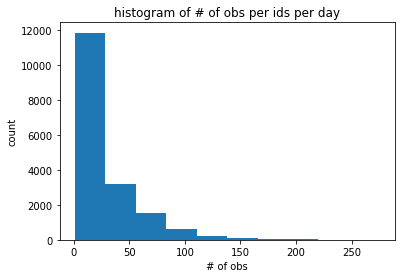

In [250]:
plt.hist(obs_sum['num_obs'])
plt.title('histogram of # of obs per ids per day')
plt.xlabel('# of obs')
plt.ylabel('count')

In [159]:
sim_result = pd.read_csv('sim_result_01.csv')
sim_result_taz = pd.read_csv('sim_result_taz.csv')

# of individuals with similarity=1 (25,)
% of people whose similar pattern locate on the same day of week (with taz info): 0.28
# of individuals with similarity=1 (56,)
% of people whose similar pattern locate on the same day of week: 0.3076923076923077


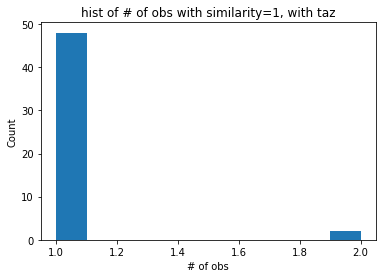

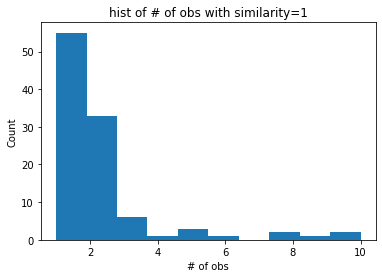

In [162]:
#get data with similarity == 1
idswithsame_pattern = sim_result_taz[['newid', 'day1', 'day2']][(sim_result_taz['jac']==1)|(sim_result_taz['cos']==1)|(sim_result_taz['tanimo']==1)|(sim_result_taz['ham']==1)]
print('# of individuals with similarity=1', idswithsame_pattern.groupby(by=['newid']).size().shape)
idx = 0
 
for ids, day1, day2 in idswithsame_pattern.values:
    ids_obs_sum = np.array([int(ids), int(day1), int(day2),
                            int(obs_sum[['num_obs']][(obs_sum['newid']==int(ids))&(obs_sum['day']==int(day1))].values[0][0])])
    if idx == 0:
        obs_sum_sim_taz = ids_obs_sum
        idx = 1
    else:
        obs_sum_sim_taz = np.vstack((obs_sum_sim_taz, ids_obs_sum))

plt.figure(1)
plt.hist(obs_sum_sim_taz[:, 3])
plt.title('hist of # of obs with similarity=1, with taz')
plt.xlabel('# of obs')
plt.ylabel('Count')

#check if similar patterns happens at the same day of week, e.g., this monday vs next monday
idswithsame_pattern['day1_tr'] = idswithsame_pattern['day1']%3
idswithsame_pattern['day2_tr'] = idswithsame_pattern['day2']%3

print('% of people whose similar pattern locate on the same day of week (with taz info):',
     np.sum(idswithsame_pattern['day1_tr'] == idswithsame_pattern['day2_tr'])/idswithsame_pattern.shape[0])


idswithsame_pattern = sim_result[['newid', 'day1', 'day2']][(sim_result['jac']==1)|(sim_result['cos']==1)|(sim_result['tanimo']==1)|(sim_result['ham']==1)]
print('# of individuals with similarity=1', idswithsame_pattern.groupby(by=['newid']).size().shape)
idx = 0
 
for ids, day1, day2 in idswithsame_pattern.values:
    ids_obs_sum = np.array([int(ids), int(day1), int(day2),
                            int(obs_sum[['num_obs']][(obs_sum['newid']==int(ids))&(obs_sum['day']==int(day1))].values[0][0])])
    if idx == 0:
        obs_sum_sim1 = ids_obs_sum
        idx = 1
    else:
        obs_sum_sim1 = np.vstack((obs_sum_sim1, ids_obs_sum))

plt.figure(2)
plt.hist(obs_sum_sim1[:, 3])
plt.title('hist of # of obs with similarity=1')
plt.xlabel('# of obs')
plt.ylabel('Count')

#check if similar patterns happens at the same day of week, e.g., this monday vs next monday
idswithsame_pattern['day1_tr'] = idswithsame_pattern['day1']%3
idswithsame_pattern['day2_tr'] = idswithsame_pattern['day2']%3

print('% of people whose similar pattern locate on the same day of week:',
     np.sum(idswithsame_pattern['day1_tr'] == idswithsame_pattern['day2_tr'])/idswithsame_pattern.shape[0])

In [321]:
date_idx = np.unique(dt12days['date'])
date_dict = {}
idx = 0
for i in date_idx:
    date_dict[i] = idx
    idx += 1
daytransfer = lambda x: date_dict[x]
dt12days['dayidx'] = dt12days['date'].apply(daytransfer)

Text(0, 0.5, 'taz idx')

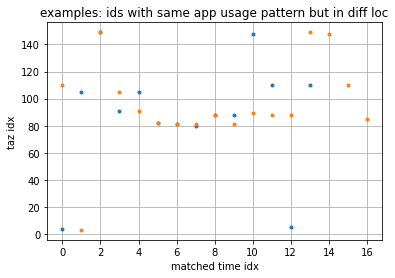

In [335]:
plt.plot(dt12days[(dt12days['newid']== 25919) & (dt12days['dayidx']==1)].sort_values(by=['timeidx']).values[:, -3], '.')
plt.plot(dt12days[(dt12days['newid']== 25919) & (dt12days['dayidx']==10)].sort_values(by=['timeidx']).values[:, -3], '.')
plt.grid()
plt.title('examples: ids with same app usage pattern but in diff loc')
plt.xlabel('matched time idx')
plt.ylabel('taz idx')

In [342]:
#similarity check
#obs record [ 25919,      1,     10,     10]
print(sim_result_taz.groupby(by=['newid']).mean().describe())

print(sim_result.groupby(by=['newid']).mean().describe())

               day1          day2          jac          cos          ham  \
count  1.468000e+03  1.468000e+03  1468.000000  1468.000000  1468.000000   
mean   3.333333e+00  7.666667e+00     0.057742     0.192491     0.859180   
std    8.884811e-16  7.729785e-14     0.077914     0.152296     0.110287   
min    3.333333e+00  7.666667e+00     0.000000     0.000624     0.246423   
25%    3.333333e+00  7.666667e+00     0.008937     0.078360     0.800965   
50%    3.333333e+00  7.666667e+00     0.027270     0.145063     0.888152   
75%    3.333333e+00  7.666667e+00     0.076860     0.271546     0.944181   
max    3.333333e+00  7.666667e+00     0.565186     0.845077     0.993792   

            tanimo  
count  1468.000000  
mean      0.002439  
std       0.005450  
min       0.000027  
25%       0.000597  
50%       0.001199  
75%       0.002286  
max       0.131768  
               day1          day2          jac          cos          ham  \
count  1.468000e+03  1.468000e+03  1468.000000  14

In [355]:
sim_result_cb = pd.merge(sim_result, sim_result_taz, on=['newid','day1','day2'])
sim_result_cb.columns = ['newid', 'day1', 'day2', 
                         'jac_01', 'cos_01', 'ham_01', 'tanimo_01', 
                         'jac_taz','cos_taz', 'ham_taz', 'tanimo_taz']
#del(sim_result, sim_result_taz)
sim_result_cb['jac_diff'] = sim_result_cb['jac_01'] - sim_result_cb['jac_taz']
sim_result_cb['cos_diff'] = sim_result_cb['cos_01'] - sim_result_cb['cos_taz']
sim_result_cb['ham_diff'] = sim_result_cb['ham_01'] - sim_result_cb['ham_taz']
sim_result_cb['tanimo_diff'] = sim_result_cb['tanimo_01'] - sim_result_cb['tanimo_taz']

In [358]:
sim_result_cb.columns

Index(['newid', 'day1', 'day2', 'jac_01', 'cos_01', 'ham_01', 'tanimo_01',
       'jac_taz', 'cos_taz', 'ham_taz', 'tanimo_taz', 'jac_diff', 'cos_diff',
       'ham_diff', 'tanimo_diff'],
      dtype='object')

In [359]:
sim_result_cb[['jac_diff', 'cos_diff','ham_diff', 'tanimo_diff']].describe()

,jac_diff,cos_diff,ham_diff,tanimo_diff
count,96888.000000,96888.000000,96888.000000,96888.000000
mean,0.075913,0.024937,0.014511,0.131217
std,0.107294,0.086121,0.030576,0.152997
min,0.000000,-0.828049,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.039216,0.000000,0.003472,0.085155
75%,0.111111,0.034601,0.013889,0.198357
max,1.000000,0.922328,0.677083,0.996942


Text(0.5, 1.0, 'similarity hist with taz trajectory')

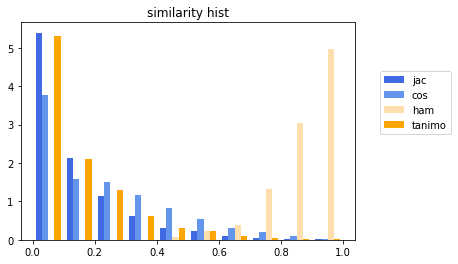

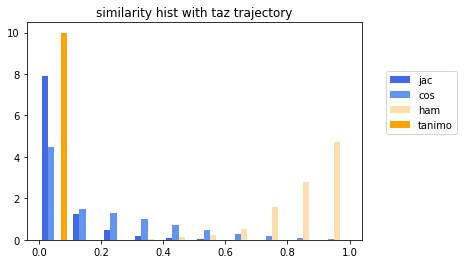

In [295]:
colors = ['royalblue', 'cornflowerblue', 'navajowhite', 'orange']
n_bins = 10
fig, ax0 = plt.subplots()

ax0.hist(sim_result[['jac', 'cos', 'ham', 'tanimo']].values, 
         n_bins, density=True, histtype='bar', color=colors, 
         label=['jac', 'cos', 'ham', 'tanimo'])

ax0.legend(loc='best', bbox_to_anchor=(0.8,0,0.5,0.8),
           prop={'size': 10})
ax0.set_title('similarity hist')

colors = ['royalblue', 'cornflowerblue', 'navajowhite', 'orange']
n_bins = 10
fig, ax0 = plt.subplots()

ax0.hist(sim_result_taz[['jac', 'cos', 'ham', 'tanimo']].values, 
         n_bins, density=True, histtype='bar', color=colors, 
         label=['jac', 'cos', 'ham', 'tanimo'])

ax0.legend(loc='best', bbox_to_anchor=(0.8,0,0.5,0.8),
           prop={'size': 10})
ax0.set_title('similarity hist with taz trajectory')

Based on previous data exploration, it is found that people with similar app-usage pattern != people with similar trajectory, even for the same people within different days.

### 3d data processing (combine time, spacial and obs info)

In [41]:
def get_sim_result_3d(mx, newid):
    num_row = mx.shape[0]
    idx = 0
    for i in range(num_row-1):
        for j in range(i+1, num_row):
            if idx == 0:
                sim_mx = cal_similarity(mx[i], mx[j])
                sim_mx = np.hstack(([newid, i,j], sim_mx))
                idx = 1
            else:
                cur_mx = cal_similarity(mx[i], mx[j])
                cur_mx = np.hstack(([newid, i,j], cur_mx))
                sim_mx = np.vstack((sim_mx, cur_mx))
    sim_result = pd.DataFrame(sim_mx)
    sim_result.columns = ['newid', 'day1', 'day2', 'jac', 'cos', 'ham', 'tanimo']
    #print(sim_result.describe())
    return(sim_result)

In [42]:
#ids = np.unique(dt12days.newid)
idx = 0
for ids in np.unique(dt12days['newid']):
    testdt = dt12days[dt12days['newid']==ids]
    mx3d, mx2dtaz, mx2d01 = convertdt2mx(testdt, dt12days)
    mx3d = mx3d.reshape(mx3d.shape[0], -1)
    #print(mx3d.shape)
    if idx == 0:
        sim_result_ts = get_sim_result_3d(mx3d, ids)
        idx = 1
    else:
        cur_result = get_sim_result(mx3d, ids)
        sim_result_ts = pd.concat((sim_result_ts, cur_result))

In [123]:
#same people, but different day
sim_result_ts.to_csv('sim_result_ts.csv')
sim_result_ts[sim_result_ts['jac']!=1].describe()

,newid,day1,day2,jac,cos,ham,tanimo
count,96879.000000,96879.000000,96879.000000,96879.000000,96879.000000,96879.000000,96879.000000
mean,229384.913624,3.333344,7.666760,0.054889,0.096494,0.998875,0.054889
std,135172.265901,2.687436,2.687433,0.088589,0.138756,0.000990,0.088589
min,32.000000,0.000000,1.000000,0.000000,0.000000,0.989375,0.000000
25%,105717.000000,1.000000,6.000000,0.000000,0.000000,0.998482,0.000000
50%,229610.000000,3.000000,8.000000,0.011765,0.025717,0.999148,0.011765
75%,348220.000000,5.000000,10.000000,0.078431,0.154303,0.999584,0.078431
max,458380.000000,10.000000,11.000000,0.827957,0.907454,0.999979,0.827957


In [125]:
sameday_result = sim_result_ts[sim_result_ts['jac']!=1].describe()

print('mean', sameday_result.iloc[1, :])
print('\n')
print('max', sameday_result.iloc[-1, :])

mean newid     229384.913624
day1           3.333344
day2           7.666760
jac            0.054889
cos            0.096494
ham            0.998875
tanimo         0.054889
Name: mean, dtype: float64


max newid     458380.000000
day1          10.000000
day2          11.000000
jac            0.827957
cos            0.907454
ham            0.999979
tanimo         0.827957
Name: max, dtype: float64


In [70]:
for newid, day1, day2 in sim_result_ts[['newid','day1','day2']][sim_result_ts['cos']==1].values:
    print(int(newid), int(day1%3), int(day2%3), int(day1), int(day2),
          obs_sum[['num_obs']][(obs_sum['day']==day1)&(obs_sum['newid']==newid)].values[0])

8947 2 1 2 7 [1.]
95455 1 0 1 3 [1.]
108841 2 1 5 7 [1.]
139975 2 0 8 9 [1.]
167258 0 2 0 8 [1.]
307490 1 1 1 7 [1.]
326739 2 0 2 3 [1.]
343696 0 2 3 5 [1.]
343696 1 2 7 11 [2.]


In [129]:
#different people, within same day
newids = np.unique(dt12days['newid'])
num_ids = len(newids)

def get_mx(dt12days, ids):
    testdt = dt12days[dt12days['newid']==ids]
    mx3d = convertdt2mx(testdt, dt12days, return_3d=True)
    return mx3d.reshape(mx3d.shape[0], -1)

def get_simresult_sameday(mx1, mx2, ids1, ids2):
    num_row = mx1.shape[0]
    idx = 0
    for d in range(num_row):
        if idx == 0:
            sim_mx = cal_similarity(mx1[d], mx2[d])
            sim_mx = np.hstack(([ids1, ids2, d], sim_mx))
            idx = 1
        else:
            cur_mx = cal_similarity(mx1[d], mx2[d])
            cur_mx = np.hstack(([ids1, ids2, d], cur_mx))
            sim_mx = np.vstack((sim_mx, cur_mx))
    sim_result = pd.DataFrame(sim_mx)
    sim_result.columns = ['id1', 'id2', 'day', 'jac', 'cos', 'ham', 'tanimo']
    #print(sim_result.describe())
    return(sim_result)
'''
idx = 0
for i in range(num_ids-1):
    for j in range(i+1, num_ids):
        if i>= 751 and j >1154:
            mx_i = get_mx(dt12days, newids[i])
            mx_j = get_mx(dt12days, newids[j])
            if idx == 0:
                sim_result_idsameday2 = get_simresult_sameday(mx_i, mx_j, newids[i], newids[j])
                idx = 1
            else:
                cur_result = get_simresult_sameday(mx_i, mx_j, newids[i], newids[j])
                sim_result_idsameday2 = pd.concat((sim_result_idsameday2, cur_result))

sim_result_idsameday = pd.concat((sim_result_idsameday, sim_result_idsameday2))'''

In [91]:
ids_dict = {}
idx = 0
for i in newids:
    ids_dict[i] = idx
    idx += 1

In [168]:
sim_result_ts.jac[sim_result_ts.jac!=0]

0     0.148148
1     0.108108
2     0.197917
3     0.259259
4     0.206349
        ...   
31    0.080000
33    0.100000
37    0.062500
46    0.081081
59    0.034483
Name: jac, Length: 49724, dtype: float64

In [184]:
sim_result_idsameday

,id1,id2,day,jac,cos,ham,tanimo
0,32.0,595.0,0.0,0.0,0.0,0.998919,0.0
1,32.0,595.0,1.0,0.0,0.0,0.998565,0.0
2,32.0,595.0,2.0,0.0,0.0,0.998877,0.0
3,32.0,595.0,3.0,0.0,0.0,0.998129,0.0
4,32.0,595.0,4.0,0.0,0.0,0.998461,0.0
...,...,...,...,...,...,...,...
7,458213.0,458380.0,7.0,0.0,0.0,0.999314,0.0
8,458213.0,458380.0,8.0,0.0,0.0,0.999314,0.0
9,458213.0,458380.0,9.0,0.0,0.0,0.999355,0.0
10,458213.0,458380.0,10.0,0.0,0.0,0.999397,0.0


In [185]:
#similarity parameters check
def get_para(sim_result):
    print('data descrip with sim>0', sim_result[sim_result['jac']!=0].describe())
    num_idg1 = len(np.unique(sim_result['newid'][sim_result['jac']!=0]))
    num_id = len(np.unique(sim_result['newid']))
    print(f'\n# of ids = {num_id}, # of ids with sim>0 = {num_idg1}, % = {num_idg1/num_id}')
    

def plot_hist(sim_result):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 6))
    fig.suptitle('hist of the similarity')
    ax1.set_title('jac, w.o. 0')
    ax1.hist(sim_result[['jac']][sim_result['jac']!=0].values)
    ax2.set_title('jac')
    ax2.hist(sim_result[['jac']])
    
    ax3.set_title('cos, w.o. 0')
    ax3.hist(sim_result[['cos']][sim_result['cos']!=0])
    ax4.set_title('cos')
    ax4.hist(sim_result[['cos']])


data descrip with sim>0                newid          day1          day2           jac           cos  \
count   49724.000000  49724.000000  49724.000000  49724.000000  49724.000000   
mean   231813.311821      3.342209      7.645543      0.107122      0.188183   
std    137196.219800      2.692796      2.689466      0.099328      0.142902   
min        32.000000      0.000000      1.000000      0.003012      0.006090   
25%    105010.000000      1.000000      6.000000      0.037500      0.078947   
50%    231711.000000      3.000000      8.000000      0.076433      0.150075   
75%    355892.000000      5.000000     10.000000      0.142857      0.258544   
max    458380.000000     10.000000     11.000000      1.000000      1.000000   

                ham        tanimo  
count  49724.000000  49724.000000  
mean       0.998439      0.107122  
std        0.001079      0.099328  
min        0.989375      0.003012  
25%        0.997983      0.037500  
50%        0.998669      0.076433  
75%

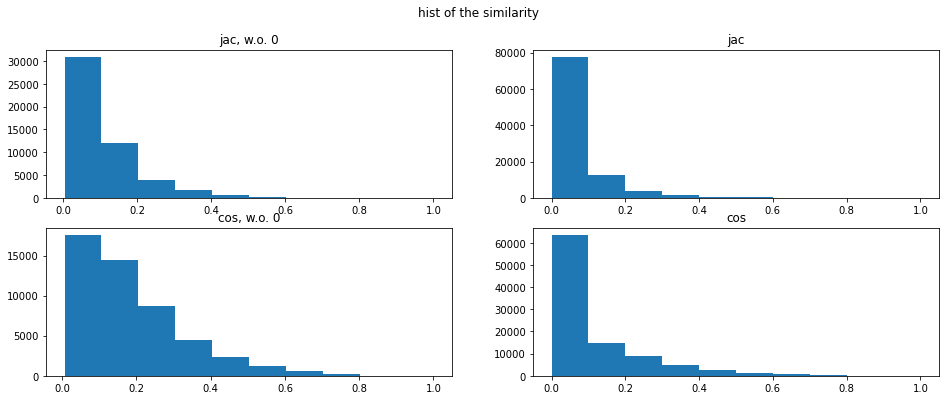

In [186]:
#iner comparison between individuals
get_para(sim_result_ts)
plot_hist(sim_result_ts)

In [ ]:
#individuals vs individuals
#sim_result_idsameday.to_csv('C:\\Users\\Yiran\\Desktop\\YiranZhang\\sim_result_idsameday.csv')

In [212]:
sim_result_idsameday[sim_result_idsameday['jac']!=0].describe()

,id1,id2,day,jac,cos,ham,tanimo
count,256582.000000,256582.000000,256582.000000,256582.000000,256582.000000,256582.000000,256582.000000
mean,144365.813857,310315.198712,5.494150,0.020512,0.046000,0.997748,0.020512
std,110814.489456,113144.297751,3.448991,0.024620,0.046735,0.001280,0.024620
min,32.000000,1197.000000,0.000000,0.001653,0.003496,0.987442,0.001653
25%,55687.000000,222550.000000,2.000000,0.008403,0.019811,0.997089,0.008403
50%,116151.000000,337132.000000,6.000000,0.012987,0.031311,0.997983,0.012987
75%,211645.000000,405704.000000,8.000000,0.022472,0.053300,0.998649,0.022472
max,457200.000000,458380.000000,11.000000,0.666667,0.816497,0.999979,0.666667


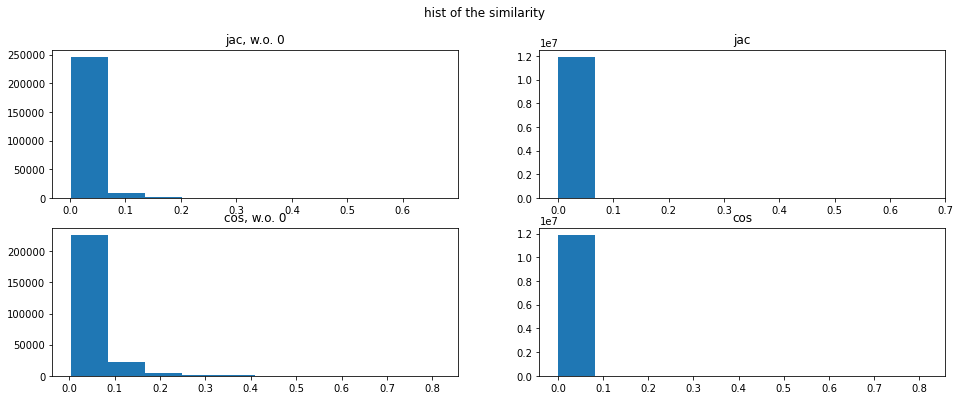

In [187]:
plot_hist(sim_result_idsameday)

Text(0, 0.5, 'total # of pair')

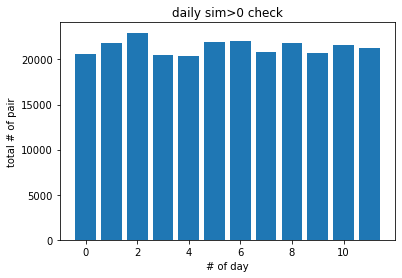

In [216]:
#daypair check
daypair = sim_result_idsameday[sim_result_idsameday['jac']!=0].groupby(['day']).size().to_frame()

plt.figure(1)
plt.bar(daypair.index, daypair[0])
plt.title('daily sim>0 check')
plt.xlabel('# of day')
plt.ylabel('total # of pair')

Text(0.5, 0, '# of days')

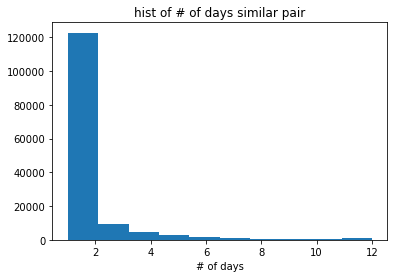

In [227]:
#pair check
#sim_result_idsameday['idpair'] = sim_result_idsameday['id1'].astype(str)+'_'+sim_result_idsameday['id2'].astype(str)
idspair = sim_result_idsameday[sim_result_idsameday['jac']!=0].groupby(['idpair']).size().to_frame()
plt.figure(1)
plt.title('hist of # of days similar pair')
plt.hist(idspair[0])
plt.xlabel('# of days')

In [222]:
idspair = sim_result_idsameday[sim_result_idsameday['jac']!=0].groupby(['idpair', 'day']).size().to_frame()
idspair.reset_index(inplace=True)

Text(0.5, 0, 'day idx')

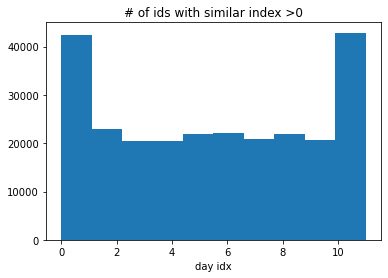

In [226]:
plt.title('# of ids with similar index >0')
plt.hist(idspair['day'])
plt.xlabel('day idx')

In [164]:
print(sim_result_idsameday[['day', 'jac', 'cos']].describe())
cur = sim_result_idsameday[['day', 'jac', 'cos']].describe()

                day           jac           cos
count  1.194930e+07  1.194930e+07  1.194930e+07
mean   5.500000e+00  4.404478e-04  9.877319e-04
std    3.452053e+00  4.675090e-03  9.558201e-03
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    2.750000e+00  0.000000e+00  0.000000e+00
50%    5.500000e+00  0.000000e+00  0.000000e+00
75%    8.250000e+00  0.000000e+00  0.000000e+00
max    1.100000e+01  6.666667e-01  8.164966e-01


In [150]:
print('mean', cur.iloc[1, :])

mean day    5.500000
jac    0.000440
cos    0.000988
Name: mean, dtype: float64


In [158]:
print('max', cur.iloc[-1, :])

max day    11.000000
jac     0.666667
cos     0.816497
Name: max, dtype: float64


array([[9.84594000e+06, 9.84594000e+06, 9.84594000e+06],
       [5.50000000e+00, 4.32697234e-04, 9.70372727e-04],
       [3.45205270e+00, 4.63663998e-03, 9.46694672e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.75000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.50000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.25000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.10000000e+01, 6.66666667e-01, 8.16496581e-01]])

In [75]:
dt12days[(dt12days['newid']==343696)&(dt12days['date'].isin([19, 27]))]

,newid,sum,key,taz,date,time,tazidx,timeidx
166856,343696,1,19_15_20_430,430,19,15:20,5,184
166855,343696,1,19_15_25_432,432,19,15:25,7,185
156176,343696,1,27_15_20_430,430,27,15:20,5,184
156177,343696,1,27_15_25_432,432,27,15:25,7,185


In [62]:
obs_sum[obs_sum['num_obs']>10].shape

(11076, 3)

In [ ]:
sim_result_idsameday.describe()

True

In [ ]:
dt12days[dt12days]

In [370]:
mx3d[0].shape

(288, 167)

In [221]:
from sklearn.cluster import SpectralCoclustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

#2d clustering

scaler = StandardScaler()
mx2d_scaled = scaler.fit_transform(mx2d)

eps = 0.3
min_samples = 2
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

labels = dbscan.fit_predict(mx2d_scaled)
silhouette_score(mx2d_scaled, model.row_labels_)

-0.01883441336856574

In [217]:
labels

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

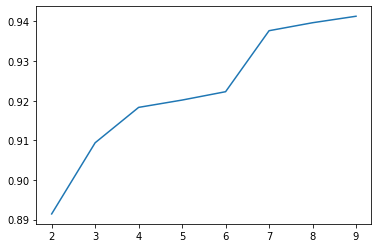

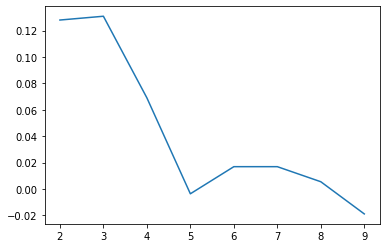

In [220]:
#3d clustering
X = mx3d.reshape(nx*ny, nz)
paras = []
paras2d = []
for k in range(2, 10):
    n_clusters = k
    model = SpectralCoclustering(n_clusters=n_clusters)
    model.fit(X)
    row_labels = model.row_labels_
    paras.append(silhouette_score(X, model.row_labels_))
    
    model = SpectralCoclustering(n_clusters=n_clusters)
    model.fit(mx2d)
    row_labels = model.row_labels_
    paras2d.append(silhouette_score(mx2d_scaled, model.row_labels_))

    # Visualize the cluster assignments
    #fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Cluster assignments for rows (days)
    
plt.figure(1)   
plt.plot(np.arange(2, 10), paras)

plt.figure(2)
plt.plot(np.arange(2, 10), paras2d)
#ax[0].imshow(X[np.argsort(row_labels)], cmap='viridis')
#ax[0].set_title('Row Clustering (Days)')
#ax[0].set_xlabel('Zone ID')
#ax[0].set_ylabel('Day')

# Cluster assignments for columns (minutes of the day)
#column_labels = model.column_labels_
#ax[1].imshow(X[:, np.argsort(column_labels)], cmap='viridis', aspect='auto')
#ax[1].set_title('Column Clustering (5-Minutes of the Day)')
#ax[1].set_xlabel('Zone ID')
#ax[1].set_ylabel('5-Minute of the Day')

#plt.tight_layout()
#plt.show()

In [182]:
testdt.sort_values(by=['date', 'timeidx']).head(20)

,newid,sum,key,taz,date,time,timeidx
28,32,1,4_6_35_653,653,4,6:35,79
14,32,1,4_6_40_512,512,4,6:40,80
21,32,1,4_6_40_521,521,4,6:40,80
15,32,2,4_6_45_501,501,4,6:45,81
37,32,1,4_6_45_502,502,4,6:45,81
6,32,1,4_6_55_502,502,4,6:55,83
39,32,1,4_8_20_502,502,4,8:20,100
20,32,1,4_8_25_502,502,4,8:25,101
12,32,1,4_8_30_502,502,4,8:30,102
13,32,1,4_8_40_502,502,4,8:40,104


In [125]:
testdt.head(3)

,newid,sum,key,taz,date,time,timeidx
4,32,1,4_11_35_502,502,4,11:35,139
5,32,1,4_12_10_502,502,4,12:10,146
6,32,1,4_6_55_502,502,4,6:55,83


In [47]:
app_test_dt = app_test_dt.sort_values(by=['time'])

In [12]:
app_test_ = app_test_dt.groupby(by=['newid', 'taz']).size().to_frame()
app_test_.reset_index(inplace=True)

app_test_.columns = ['newid','taz', 'num_obs']

num_obs = app_test_['num_obs'].values
app_test_.columns

app_test_ = app_test_.groupby(by=['newid','taz']).size().to_frame()
app_test_.reset_index(inplace=True)

app_taz_dt = app_test_.groupby(by=['newid']).sum()
app_taz_dt.reset_index(inplace=True)
app_taz_dt.columns = ['newid', 'taz', 'num_taz']

del(app_test_)

In [49]:
num_id_w1obs = app_taz_dt['newid'][app_taz_dt['num_taz'] == 1].values

# ids with only one taz observed within one day 3144
% ids with only one taz observed within one day 0.22933839083813554
it is found that 23% of the ids only observed once, cosidered as stay
#######################################################################################
count    3144.000000
mean        4.377226
std        17.223490
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       471.000000
Name: sum, dtype: float64
#######################################################################################
0.16616821066452694  of ids who were observed only once per day
0.015829017433802613  of ids who were observed with only one taz, (# > 10)
#######################################################################################


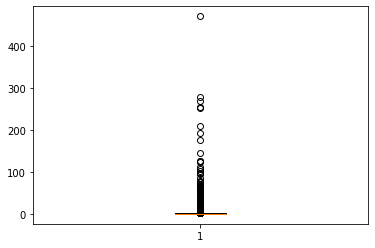

In [92]:
print('# ids with only one taz observed within one day', app_taz_dt[app_taz_dt['num_taz'] == 1].shape[0])
print('% ids with only one taz observed within one day', app_taz_dt[app_taz_dt['num_taz'] == 1].shape[0]/(app_taz_dt.shape[0]))
print('it is found that 23% of the ids only observed once, cosidered as stay') 
print('#######################################################################################')

print(app_test_dt[app_test_dt['newid'].isin(num_id_w1obs)].groupby(by=['newid']).sum()['sum'].describe())
plt.boxplot(app_test_dt[app_test_dt['newid'].isin(num_id_w1obs)].groupby(by=['newid']).sum()['sum'].values)

test_id = app_test_dt[app_test_dt['newid'].isin(num_id_w1obs)].groupby(by=['newid']).sum()['sum'].to_frame()
test_id.reset_index(inplace=True)
#15 ids more than 100 obs
#217 ids more than 10 obs 

#test_id[test_id['sum']>1].shape
print('#######################################################################################')
print(2278/len(np.unique(app_test_dt['newid'])), ' of ids who were observed only once per day')
print(test_id[test_id['sum']>10].shape[0]/len(np.unique(app_test_dt['newid'])), ' of ids who were observed with only one taz, (# > 10)')
print('#######################################################################################')

In [93]:
del(app_test_dt, app_taz_dt)